Notebook to generate the group masks that are to be passed in the subsequent analyses. Two different masks will be created:

    - One at the voxel level, for the activation and seed-based edge time series analyses. This will just be a mask with the post likely voxels belonging to grey matter, for which we'll used the segmentation files provided by fMRIPrep
    - Another one at the ROI level for the atlas-based analyses, each for any kind of parcellation employed. This mask will be just a 3D array, created from a matrix of ones in the upper triangular (omitting also the diagonals).

In [2]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from nilearn import image, plotting
import regex as re

/home/javi/Documentos/software/nilearn/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# GREY MATTER MASK FOR ACTIVATION AND SEED-BASED ANALYSES

In [44]:
for input_file in os.listdir("../data/t1_probseg_gm/t1_res/"):
        
    if input_file.endswith("GM_probseg.nii.gz") is False: 
        continue
        
    sub_id = re.findall(pattern="sub-(.*)_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz", string=input_file)[0]
    
    input_file = os.path.join("../data/t1_probseg_gm/t1_res", input_file) # Add base folder
    ref_file = "../data/preproc_bold/task-msit/sub-%s_ses-01_task-msit_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz" % sub_id
    out_file = "../data/t1_probseg_gm/bold_res/sub-%s_space-MNI152NLin2009cAsym_desc-GM_probseg.nii.gz" % sub_id
    if os.path.exists(out_file):
        continue
    cmd = "mri_vol2vol --regheader --mov %s --targ %s --o %s" % (input_file, ref_file, out_file)
    print(cmd)
    #os.system(cmd)

mri_vol2vol --regheader --mov ../segmentation/sub-2107_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz --targ ../task-msit/preproc/sub-2107_ses-01_task-msit_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz --o ../segmentation/bold_res/sub-2107_space-MNI152NLin2009cAsym_desc-GM_probseg.nii.gz
mri_vol2vol --regheader --mov ../segmentation/sub-2101_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz --targ ../task-msit/preproc/sub-2101_ses-01_task-msit_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz --o ../segmentation/bold_res/sub-2101_space-MNI152NLin2009cAsym_desc-GM_probseg.nii.gz


Create masks for each case (threshold)

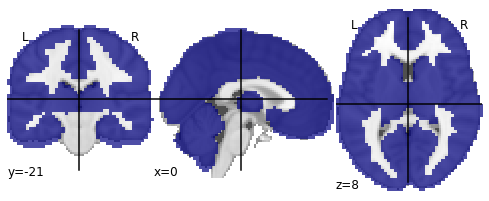

In [14]:
# Pattern to the mask
pattern_masks = "../data/t1_probseg_gm/bold_res/sub-%d_space-MNI152NLin2009cAsym_desc-GM_probseg.nii.gz" 

# Average probabilistic mask
mean_gm_seg = image.mean_img([pattern_masks % subj \
                              for subj in np.loadtxt("../data/subjects_intersect_motion_035.txt")])
# Smooth a litle this and then binarize with a liberal threshold
gm_mask = image.math_img("img>0.2", img=image.smooth_img(mean_gm_seg, fwhm=6))

gm_mask.to_filename("../data/masks/grey_mask_motion_035.nii.gz")
plotting.plot_roi(gm_mask, cut_coords=(0,-21, 8))

# EDGE ATLAS MASK

In [6]:
atlas_file = "../data/atlases/shen_2mm_268_parcellation.nii.gz"
print(atlas_file)

atlas_img = image.load_img(atlas_file)
n_rois = len(np.unique(atlas_img.get_fdata()))-1
print("the number of rois in this %s parcellation is = %d" % ("Shen", n_rois))

../data/atlases/shen_2mm_268_parcellation.nii.gz
the number of rois in this Shen parcellation is = 268


In [12]:
edge_shen_mask_data = np.zeros((n_rois, n_rois), dtype=int)
edge_shen_mask_data[np.triu_indices_from(edge_shen_mask_data, k=1)]=1
edge_shen_mask_data = edge_shen_mask_data[:,:, None]
edge_shen_mask_img = image.new_img_like("../data/masks/grey_mask_motion_035.nii.gz", 
                                        edge_shen_mask_data, affine=np.eye(4))
edge_shen_mask_img.to_filename("../data/masks/edge_shen_mask.nii.gz")